In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import deque
from os import listdir
from os.path import isfile, join
from helpers import *
from strategies import *
import pandas_datareader.data as web
import datetime
from joblib import Parallel, delayed
from operator import add
import scipy
from scipy.stats import norm

In [2]:
mypath = 'historical_data/'
countries = sorted(['Australia', 'Japan', 'China'])
fx_dict = {'Australia':('historical_data/Forex/AUD_USD_new.csv',0),
           'Japan':('historical_data/Forex/USD_JPY_new.csv',1),
           'China':('historical_data/Forex/USD_HKD_new.csv',1)}

list_pairs = []
for country in countries:
    countrypath = mypath + country
    adr_names =  [f for f in listdir(countrypath) if not isfile(join(countrypath, f))] #grab all adr names of the country
    for adr in sorted(adr_names):
        list_pairs.append((country, adr))
list_pairs_copy = list_pairs.copy()

In [3]:
# Pairs we have chosen to trade
list_pairs = [("Japan", "SMFG_8316"), 
              ("Japan", "IX_8591"),
              ("Japan", "TM_7203"),
              ("Japan", "MFG_8411"),
              ("China", "BGNE_6160"), 
              ("China", "SNP_386"), 
              ("China", "HNP_902"), 
              ("China", "CEA_670"),
              ("China", "ACH_2600"),
              ("Australia", "MESO_MSB"),
              ("Australia", "IMMP_IMM"),
              ("Australia", "PLL_PLL"),
              ("Australia", "KZIA_KZA"),
              ("Australia", "IMRN_IMC")]

list_pairs_aus = [i for i in list_pairs if i[0][0] == "A"]
list_pairs_chi = [i for i in list_pairs if i[0][0] == "C"]
list_pairs_jap = [i for i in list_pairs if i[0][0] == "J"]

In [4]:
with open('logs/results_all.txt') as f:
    res = f.readlines()

hp = {}
for i in range(len(list_pairs_copy)):
    hp[list_pairs_copy[i]] = [float(x) for x in res[i*5 + 4].split("(")[1].split(")")[0].split(", ")]

df_dict = {}
for (country, adr) in list_pairs_copy:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
date_set = set()
for (country, adr) in list_pairs_copy:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
date_set.add("2015-04-08")
datelist = sorted(date_set)

In [5]:
def final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, cash = 250000, 
                   start_date = "2016-01-01", end_date = "2021-01-31", slippage_bps = 10, borrowing_bps = 50, 
                   risk_lookback = 100, cooldown_limit = 100, var_ci = 0.95, var_limit = 0.1, 
                   max_drawdown_limit = 0.2, sigma_limit = 0.05, stop_loss_limit = 0.15, maximum_holding_period = 30, 
                   volume_lookback = 5, adjust_for_risk = True):

    # Number of pairs from each country we will trade at each time
    num_traded = {"Australia" : [], "China" : [], "Japan" : []}

    hp_dict = {}
    for (country, adr) in list_pairs:
        hp_dict[(country, adr)] = {}
        hp_dict[(country, adr)]["lookback"] = int(hp[(country, adr)][0])
        hp_dict[(country, adr)]["entry"] = hp[(country, adr)][1]
        hp_dict[(country, adr)]["exit"] = hp[(country, adr)][2]
        hp_dict[(country, adr)]["actual_entries"] = []
        hp_dict[(country, adr)]["actual_exits"] = []
        hp_dict[(country, adr)]["stop_loss"] = hp[(country, adr)][3]
        # Fraction of cash allocated to each adr-stock pair
        hp_dict[(country, adr)]["allocation"] = allocation[country]/trading_limits[country]
        hp_dict[(country, adr)]["original_allocation"] = allocation[country]/trading_limits[country]

    diff_record_dict = {}
    for (country, adr) in list_pairs:
        diff_record_dict[(country, adr)] = deque(maxlen = 2*hp_dict[(country, adr)]["lookback"])

    conditions = {}
    for (country, adr) in list_pairs:
        conditions[(country, adr)] = {}
        conditions[(country, adr)]["enter_cond1"] = False
        conditions[(country, adr)]["exit_cond1"] = False
        conditions[(country, adr)]["enter_cond2"] = False
        conditions[(country, adr)]["exit_cond2"] = False

    iter_dict = {}
    for (country, adr) in list_pairs:
        iter_dict[(country, adr)] = {}
        iter_dict[(country, adr)]["index"] = 0

    positions = {}
    for (country, adr) in list_pairs:
        positions[(country, adr)] = {}
        positions[(country, adr)]["stock_pos"] = 0
        positions[(country, adr)]["adr_pos"] = 0
        positions[(country, adr)]["prev_adr_pos"] = 0
        positions[(country, adr)]["holding_period"] = None
        positions[(country, adr)]["trade_type"] = None

    forex_dict = {}
    for (country, adr) in list_pairs:
        forex_dict[(country, adr)] = {}
        forex_dict[(country, adr)]["forex_cash"] = 0
        forex_dict[(country, adr)]["prev_forex_value"] = 0

    trade_records = []
    portfolio_values = []
    portfolio_values_for_risk = []
    dates = []
    # Determine if risk limits have been breached
    breach1 = False
    breach2 = False
    cooldown = cooldown_limit
    reduced_allocation_cooldown = cooldown_limit
    
    # Accounts for slippage and transaction costs
    short_multiplier = 1 - 0.0001*slippage_bps
    long_multiplier = 1 + 0.0001*slippage_bps
    starting_cash = cash
    # For book-keeping, since we shall store the portfolio value of the day before
    prev_cash = cash
    
    for i in range(1, len(datelist)):
        current_date = datelist[i]
        prev_date = datelist[i-1]
        if current_date >= start_date and prev_date <= end_date:
            # Log number of stocks traded in each country
            # Log portfolio value of the day before, when the Asian market opens
            cooldown += 1
            reduced_allocation_cooldown += 1
            dates.append(prev_date)
            prev_value = prev_cash
            for country in countries:
                num_traded[country].append(0)
            for (country, adr) in list_pairs:
                index = iter_dict[(country, adr)]["index"]
                merged_df = df_dict[(country, adr)]
                row = merged_df.loc[index]
                if positions[(country, adr)]["stock_pos"] > 0:
                    num_traded[country][-1] += 1
                if index > 0:
                    # Add adr values
                    prev_value += positions[(country, adr)]["prev_adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                    # Add stock values
                    forex_dict[(country, adr)]["prev_forex_value"] = forex_dict[(country, adr)]["forex_cash"] 
                    forex_dict[(country, adr)]["prev_forex_value"] += positions[(country, adr)]["stock_pos"]*row['stock_open']
                    if forex_dict[(country, adr)]["prev_forex_value"] > 0:
                        # For our convention, ask price is the price of selling foreign currency (how much foreign currency to sell for 1 USD)
                        # Ask price > Bid price
                        forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_ask_non_us_at']
                    elif forex_dict[(country, adr)]["prev_forex_value"] < 0:
                        forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_bid_non_us_at']
                    prev_value += forex_dict[(country, adr)]["prev_forex_value"]
            portfolio_values.append(prev_value)
            portfolio_values_for_risk.append(prev_value)

            # Account for borrowing cost
            for (country, adr) in list_pairs:
                index = iter_dict[(country, adr)]["index"]
                merged_df = df_dict[(country, adr)]
                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                if positions[(country, adr)]["stock_pos"] > 0:
                    positions[(country, adr)]["holding_period"] += 1
                    # Cost of shorting stock
                    cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
                    # Cost of shorting cash
                    multiplier = (1 + 0.01*(2 + merged_df.loc[index]["ir"])*(1/252))
                    forex_dict[(country, adr)]["forex_cash"] *= multiplier
            prev_cash = cash

            # Risk Tests
            if reduced_allocation_cooldown == cooldown_limit:
                for (country, adr) in list_pairs:
                    hp_dict[(country, adr)]["allocation"] = hp_dict[(country, adr)]["original_allocation"]
            
            if cooldown >= cooldown_limit and adjust_for_risk:
                max_drawdown = calc_max_drawdown(portfolio_values_for_risk, method = "absolute")
                starting_cash = portfolio_values_for_risk[0]
                cum_pl = prev_value - starting_cash
                # Fraction to liquidate
                liquidate_frac = 0
                # If max drawdown / cum PnL hits 50% or 75% of limit
                # Liquidate a fraction of positions and reduce the amount traded for future transactions
                # If max drawdown / cum PnL hits 100% of limit
                # Liquidate all positions, stop trading for {cooldown} days, reset all risk measures
                if max_drawdown > max_drawdown_limit*starting_cash or cum_pl < -stop_loss_limit*starting_cash:
                    liquidate_frac = 1
                    cooldown = 0
                    portfolio_values_for_risk = []
                    breach1 = False
                    breach2 = False
                    # Return to original allocation after cooldown.
                    # In real-life, someone would step in and redecide if this is appropriate
                    for (country, adr) in list_pairs:
                        hp_dict[(country, adr)]["allocation"] = hp_dict[(country, adr)]["original_allocation"]
                elif (max_drawdown > 0.75*max_drawdown_limit*starting_cash or cum_pl < -0.75*stop_loss_limit*starting_cash) and not breach2:
                    liquidate_frac = 0.5
                    for (country, adr) in list_pairs:
                        hp_dict[(country, adr)]["allocation"] = hp_dict[(country, adr)]["original_allocation"]*(1/3)
                    breach2 = True
                    reduced_allocation_cooldown = 0
                elif (max_drawdown > 0.5*max_drawdown_limit*starting_cash or cum_pl < -0.5*stop_loss_limit*starting_cash) and not breach1:
                    liquidate_frac = 1/3
                    for (country, adr) in list_pairs:
                        hp_dict[(country, adr)]["allocation"] = hp_dict[(country, adr)]["original_allocation"]*(1/2)
                    breach1 = True
                    reduced_allocation_cooldown = 0

                # Calculate VaR and PnL volatility for each prior day at Asian market open
                # Further adjust fraction to liquidate based on these risk limits
                stock_values = np.zeros(risk_lookback)
                adr_values = np.zeros(risk_lookback)
                for (country, adr) in list_pairs:
                    index = iter_dict[(country, adr)]["index"]
                    merged_df = df_dict[(country, adr)]
                    if index > 0:
                        temp_risk_lookback = min(risk_lookback, index)
                        current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                        ind_stock_values = (np.array(current["stock_open"])/np.array(current["avg_non_us_at"]))*positions[(country, adr)]["stock_pos"] 
                        ind_adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*positions[(country, adr)]["adr_pos"])
                        stock_values[-len(ind_stock_values):] += ind_stock_values
                        adr_values[-len(ind_adr_values):] += ind_adr_values
                sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                if sigma > prev_value*sigma_limit:
                    new_liquidate_frac = (sigma - prev_value*sigma_limit)/(prev_value*sigma_limit)
                    liquidate_frac = max(liquidate_frac, new_liquidate_frac)

                if var > prev_value*var_limit:
                    new_liquidate_frac = (var - prev_value*var_limit)/(prev_value*var_limit)
                    liquidate_frac = max(liquidate_frac, new_liquidate_frac)

                # Liquidate if necessary
                if liquidate_frac > 0:
                    for (country, adr) in list_pairs:
                        index = iter_dict[(country, adr)]["index"]
                        merged_df = df_dict[(country, adr)]
                        if index > 0 and index+1 < len(merged_df):
                            row = merged_df.loc[index]
                            stock_pos = positions[(country, adr)]["stock_pos"]
                            adr_pos = positions[(country, adr)]["adr_pos"]
                            if stock_pos > 0:
                                units_traded = stock_pos/row["stock_num_per_unit"]
                                units_liquidated = math.ceil(units_traded*liquidate_frac)
                                stock_quantity_sold = int(units_liquidated*row["stock_num_per_unit"])
                                adr_quantity_bought = int(units_liquidated*row["adr_num_per_unit"])
                                adr_px = row['adr_open']*long_multiplier
                                cash -= adr_quantity_bought*adr_px
                                prev_cash -= adr_quantity_bought*adr_px

                                stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                leftover_forex_cash = forex_dict[(country, adr)]["forex_cash"]*liquidate_frac
                                leftover_forex_cash += stock_px_fx*stock_quantity_sold
                                forex_dict[(country, adr)]["forex_cash"] *= (1-liquidate_frac)
                                if leftover_forex_cash > 0:
                                    leftover_forex_cash /= merged_df.loc[index+1,'avg_ask_non_us_at']
                                else:
                                    leftover_forex_cash /= merged_df.loc[index+1,'avg_bid_non_us_at']
                                cash += leftover_forex_cash
                                prev_cash += leftover_forex_cash

                                trade_records.append("Liquidating positions:\n")
                                # Times in EST
                                trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                                positions[(country, adr)]["adr_pos"] += adr_quantity_bought
                                positions[(country, adr)]["stock_pos"] -= stock_quantity_sold
                                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                if liquidate_frac == 1:
                                    positions[(country, adr)]["holding_period"] = None
                                    num_traded[country][-1] += 1

        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            # Lookback parameter is in number of trading days
            lookback = 2*hp_dict[(country, adr)]["lookback"]

            if index+1 < len(merged_df):
                row = merged_df.loc[index]
                if row["date"] == current_date:
                    iter_dict[(country, adr)]["index"] += 1
                    if index > 0: 
                        diff_record = diff_record_dict[(country, adr)]
                        entry = hp_dict[(country, adr)]["entry"]
                        exit = hp_dict[(country, adr)]["exit"]
                        stop_loss = hp_dict[(country, adr)]["stop_loss"]
                        stock_pos = positions[(country, adr)]["stock_pos"]
                        adr_pos = positions[(country, adr)]["adr_pos"]
                        holding_period = positions[(country, adr)]["holding_period"]
                        trade_type = positions[(country, adr)]["trade_type"]
                        stock_name = adr.split("_")[1]
                        adr_name = adr.split("_")[0]
                        enter_cond1 = conditions[(country, adr)]["enter_cond1"]
                        exit_cond1 = conditions[(country, adr)]["exit_cond1"]
                        enter_cond2 = conditions[(country, adr)]["enter_cond2"]
                        exit_cond2 = conditions[(country, adr)]["exit_cond2"]

                        # Before the US Market open, append price difference between ADR and stock
                        diff_record.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_us_before'])
                        if len(diff_record) == lookback and row["date"] >= start_date and row["date"] <= end_date and cooldown >= cooldown_limit:
                            mean = np.array(diff_record).mean()
                            std = np.array(diff_record).std()
                            
                            # Check that a concurrent trade was not already placed
                            if not (enter_cond2 or exit_cond2):
                                enter_cond1 = (diff_record[-1] > mean + entry*std
                                               and diff_record[-1] <= mean + stop_loss*std
                                               and stock_pos == 0 and adr_pos == 0 
                                               and num_traded[country][-1] < trading_limits[country])
                                exit_cond1 = ((diff_record[-1] < mean + exit*std
                                              or diff_record[-1] > mean + stop_loss*std
                                              or (holding_period == maximum_holding_period and trade_type == 1))
                                              and stock_pos > 0 and adr_pos < 0)

                                if enter_cond1:
                                    portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                                    # Allow ourselves to trade 20% of ADT volume over the past 5 trading days
                                    # We take the median to make this estimate more robust to extreme values
                                    adr_volume = 0.1*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].median()/row["adr_num_per_unit"])
                                    stock_volume = 0.1*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                                    units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                                    (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_us_before']), 
                                                    adr_volume, 
                                                    stock_volume))
                                    adr_quantity = int(units*row["adr_num_per_unit"])
                                    stock_quantity = int(units*row["stock_num_per_unit"])

                                    # Take portfolio value for each previous day when the US market opens
                                    # Further adjust volume based on historical max drawdown, VaR and PnL volatility
                                    temp_risk_lookback = min(risk_lookback, index)
                                    current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                                    stock_values = np.array((current["stock_close"]/current["avg_us_before"])*stock_quantity) 
                                    adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                                    if (var > portfolio_value_before_entering*var_limit*(allocation[country]) or 
                                        max_drawdown_abs > max_drawdown_limit*starting_cash*(allocation[country]) or 
                                        sigma > portfolio_value_before_entering*sigma_limit*(allocation[country])):
                                        frac = min((portfolio_value_before_entering*var_limit*(allocation[country]))/var, 
                                                   (max_drawdown_limit*starting_cash*(1/trading_limits[country]))/max_drawdown_abs,
                                                  (portfolio_value_before_entering*sigma_limit*(allocation[country]))/sigma)
                                        units = int(frac*units)
                                        if units == 0:
                                            enter_cond1 = False
                                        adr_quantity = int(units*row["adr_num_per_unit"])
                                        stock_quantity = int(units*row["stock_num_per_unit"]) 
                                        
                                    if units != 0:
                                        # Short ADR
                                        adr_pos -= adr_quantity
                                        positions[(country, adr)]["adr_pos"] -= adr_quantity
                                        adr_px = row['adr_open']*short_multiplier
                                        cash += adr_quantity*adr_px
                                        prev_cash += adr_quantity*adr_px
                                        actual_price_difference = row['adr_open_per_unit'] - row['stock_close_per_unit']/row['avg_us_before']
                                        actual_entry = (actual_price_difference - mean)/std
                                        hp_dict[(country, adr)]["actual_entries"].append(actual_entry)
                                        
                                        # Long Stock
                                        stock_pos += stock_quantity
                                        positions[(country, adr)]["stock_pos"] += stock_quantity
                                        stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                        forex_dict[(country, adr)]["forex_cash"] -= stock_px_fx*stock_quantity

                                        positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                        positions[(country, adr)]["holding_period"] = 0
                                        positions[(country, adr)]["trade_type"] = 1
                                        num_traded[country][-1] += 1

                                        trade_records.append("Opening positions:\n")
                                        # Times in EST
                                        trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                        trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                                elif exit_cond1:
                                    # Long ADR
                                    adr_px = row['adr_open']*long_multiplier
                                    cash -= abs(adr_pos)*adr_px
                                    prev_cash -= abs(adr_pos)*adr_px
                                    actual_price_difference = row['adr_open_per_unit'] - row['stock_close_per_unit']/row['avg_us_before']
                                    actual_exit = (actual_price_difference - mean)/std
                                    hp_dict[(country, adr)]["actual_exits"].append(actual_exit)
                                    
                                    # Short Stock
                                    stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                    forex_dict[(country, adr)]["forex_cash"] += stock_px_fx*stock_pos
                                    if forex_dict[(country, adr)]["forex_cash"] > 0:
                                        forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_ask_non_us_at']
                                    else:
                                        forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_bid_non_us_at']
                                    cash += forex_dict[(country, adr)]["forex_cash"]
                                    prev_cash += forex_dict[(country, adr)]["forex_cash"]
                                    forex_dict[(country, adr)]["forex_cash"] = 0

                                    trade_records.append("Closing positions:\n")
                                    # Times in EST
                                    trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                    trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                                    positions[(country, adr)]["stock_pos"] = 0
                                    positions[(country, adr)]["adr_pos"] = 0
                                    positions[(country, adr)]["holding_period"] = None
                                    positions[(country, adr)]["trade_type"] = None
                                    positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                    num_traded[country][-1] -= 1

                                conditions[(country, adr)]["enter_cond1"] = enter_cond1
                                conditions[(country, adr)]["exit_cond1"] = exit_cond1

                        # Before the Asian Market open, append price difference between ADR and stock
                        diff_record.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before'])
                        if len(diff_record) == lookback and row["date"] >= start_date and merged_df.loc[index+1,"date"] <= end_date:
                            mean = np.array(diff_record).mean()
                            std = np.array(diff_record).std()

                            # Check that a concurrent trade was not already placed
                            if not (enter_cond1 or exit_cond1):
                                enter_cond2 = (diff_record[-1] > mean + entry*std
                                               and diff_record[-1] <= mean + stop_loss*std
                                               and stock_pos == 0 and adr_pos == 0 
                                               and num_traded[country][-1] < trading_limits[country])
                                exit_cond2 = ((diff_record[-1] < mean + exit*std
                                              or diff_record[-1] > mean + stop_loss*std
                                              or (holding_period == maximum_holding_period and trade_type == 2))
                                              and stock_pos > 0 and adr_pos < 0)

                                if enter_cond2:
                                    # Allow ourselves to trade 20% of ADT volume over the past 5 trading days
                                    # We take the median to make this estimate more robust to extreme values
                                    portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                                    adr_volume = 0.1*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].median()/row["adr_num_per_unit"])
                                    stock_volume = 0.1*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                                    units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/row['adr_close_per_unit'],
                                                    (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before']), 
                                                    adr_volume, 
                                                    stock_volume))
                                    adr_quantity = int(units*row["adr_num_per_unit"])
                                    stock_quantity = int(units*row["stock_num_per_unit"])

                                    # Take portfolio value for each previous day when the Asian market opens
                                    # Further adjust volume based on historical Max Drawdown, VaR and PnL volatility
                                    temp_risk_lookback = min(risk_lookback, index)
                                    current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                                    next_day = merged_df.loc[(index - temp_risk_lookback + 2):(index + 1)].copy()
                                    stock_values = (np.array((current["stock_close"])/np.array(next_day["avg_non_us_before"]))*stock_quantity) 
                                    adr_values = np.array(current["adr_close"]*adr_quantity)
                                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                                    if (var > portfolio_value_before_entering*var_limit*(allocation[country]) or 
                                        max_drawdown_abs > max_drawdown_limit*starting_cash*(allocation[country]) or 
                                        sigma > portfolio_value_before_entering*sigma_limit*(allocation[country])):
                                        frac = min((portfolio_value_before_entering*var_limit*(allocation[country]))/var, 
                                                   (max_drawdown_limit*starting_cash*(allocation[country]))/max_drawdown_abs,
                                                  (portfolio_value_before_entering*sigma_limit*(allocation[country]))/sigma)
                                        units = int(frac*units)
                                        if units == 0:
                                            enter_cond2 = False
                                        adr_quantity = int(units*row["adr_num_per_unit"])
                                        stock_quantity = int(units*row["stock_num_per_unit"])   
                                    if units != 0:
                                        # Long stock
                                        stock_pos += stock_quantity
                                        positions[(country, adr)]["stock_pos"] += stock_quantity
                                        stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                        forex_dict[(country, adr)]["forex_cash"] -= stock_px_fx*stock_quantity
                                        # We store the current cash/adr position for book-keeping purposes, 
                                        # because the trade below will occur on the next day (EST)
                                        positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                        
                                        actual_price_difference = row['adr_close_per_unit'] - merged_df.loc[index+1,'stock_open_per_unit']/merged_df.loc[index+1,'avg_non_us_before']
                                        actual_entry = (actual_price_difference - mean)/std
                                        hp_dict[(country, adr)]["actual_entries"].append(actual_entry)
                                        
                                        # Short ADR
                                        adr_pos -= adr_quantity
                                        positions[(country, adr)]["adr_pos"] -= adr_quantity
                                        adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                                        cash += adr_quantity*adr_px

                                        positions[(country, adr)]["holding_period"] = 0
                                        positions[(country, adr)]["trade_type"] = 2
                                        num_traded[country][-1] += 1
                                        trade_records.append("Opening positions:\n")
                                        # Times in EST
                                        trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                                        trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                                # Liquidation condition
                                elif exit_cond2:
                                    # Short stock
                                    stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                    forex_dict[(country, adr)]["forex_cash"] += stock_px_fx*stock_pos
                                    if forex_dict[(country, adr)]["forex_cash"] > 0:
                                        forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_ask_non_us_at']
                                    else:
                                        forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_bid_non_us_at']
                                    cash += forex_dict[(country, adr)]["forex_cash"]
                                    prev_cash += forex_dict[(country, adr)]["forex_cash"]
                                    forex_dict[(country, adr)]["forex_cash"] = 0
                                    # We store the current cash/adr position for book-keeping purposes, 
                                    # because the trade below will occur on the next day (EST)
                                    positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                    
                                    actual_price_difference = row['adr_close_per_unit'] - merged_df.loc[index+1,'stock_open_per_unit']/merged_df.loc[index+1,'avg_non_us_before']
                                    actual_exit = (actual_price_difference - mean)/std
                                    hp_dict[(country, adr)]["actual_exits"].append(actual_exit)
                                    
                                    # Long ADR
                                    adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                                    cash -= abs(adr_pos)*adr_px
                                    trade_records.append("Closing positions:\n")
                                    # Times in EST
                                    trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                                    trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                                    positions[(country, adr)]["stock_pos"] = 0
                                    positions[(country, adr)]["adr_pos"] = 0
                                    positions[(country, adr)]["holding_period"] = None
                                    positions[(country, adr)]["trade_type"] = None
                                    num_traded[country][-1] -= 1

                                conditions[(country, adr)]["enter_cond2"] = enter_cond2
                                conditions[(country, adr)]["exit_cond2"] = exit_cond2

    return dates, portfolio_values, trade_records, num_traded, hp_dict

# Visualizing Variants

#### Want to see the difference in results for each of the variants. 

Take a random pair. Plot portfolio value over the entire period for each of the four variants on the same graph. Then, for each of the variants, plot the stock + adr, and when we buy / sell.

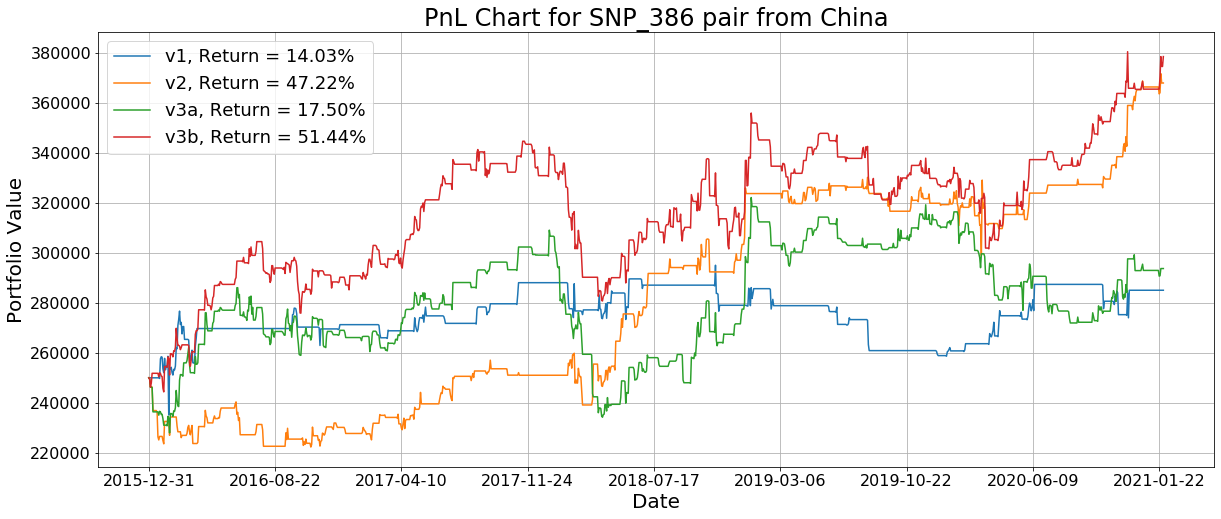

In [28]:
(country, adr) = ('China', 'SNP_386')

variants = ['1', '2', '3a', '3b']
strat = [pairs_trade_v1, pairs_trade_v2, pairs_trade_v3a, pairs_trade_v3b]

with open('logs/results_all.txt') as f:
    res = f.readlines()
f.close()

ind = res.index(f'Country: {country}, ADR_Stock: {adr}\n')
merged_df = data_processing(country, adr, fx_dict)

# Plot portfolio value over entire period for each variant on the same graph

plt.figure(figsize = (20, 8))

for v in range(1,5):
    # Get best hps
    hps = tuple(map(float, res[ind + v].split('(')[1].split(')')[0].split(", ")))
    if v <= 2:
        ret, tr, pv, hits, dates = strat[v - 1](merged_df, lookback = int(hps[0]), entry = hps[1], 
                                                exit = hps[2], stop_loss = hps[3])
    else:
        ret, tr, pv, hits, dates = strat[v - 1](merged_df, lookback = int(hps[0]), entry_cond1_val = hps[1], 
                                                entry_cond2_val = hps[1], exit_cond1_val = hps[2], exit_cond2_val = hps[2],
                                                stop_loss_cond1 = hps[3], stop_loss_cond2 = hps[3])

    plt.plot(pv, label = f'v{variants[v - 1]}, Return = {ret * 100 :.2f}%')
    xticks_indices = np.arange(0, len(dates), (len(dates)-1)//8)
    plt.xticks(xticks_indices, itemgetter(*xticks_indices)(dates), fontsize = 16)
    plt.yticks(fontsize = 16)

plt.grid(True)
plt.title(f'PnL Chart for {adr} pair from {country}', fontsize = 24)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Portfolio Value', fontsize = 20)
plt.legend(prop={'size': 18})
plt.savefig('visualizations/variants_port_values.pdf')
plt.savefig('visualizations/variants_port_values.png')

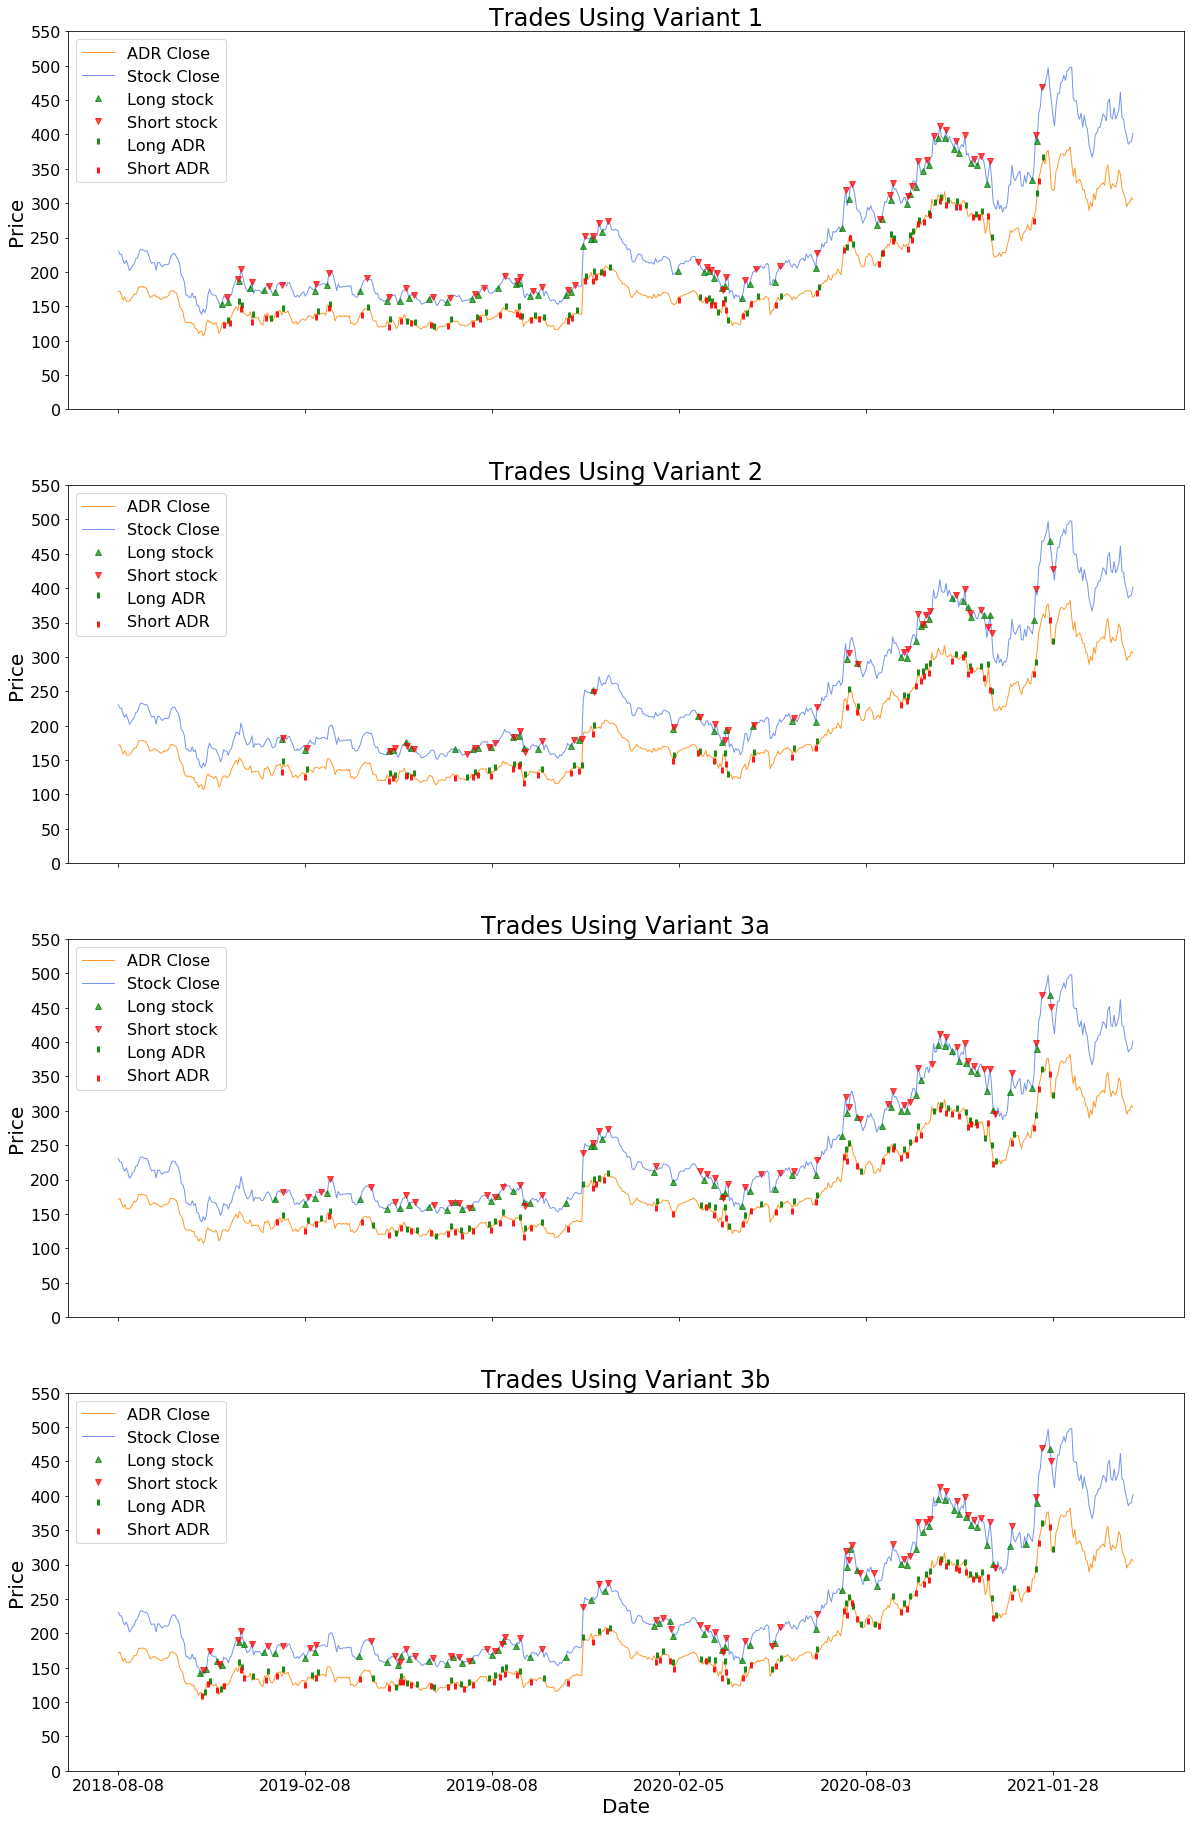

In [73]:
(country, adr) = list_pairs_copy[10]
ind = res.index(f'Country: {country}, ADR_Stock: {adr}\n')
merged_df = data_processing(country, adr, fx_dict)

fig, axs = plt.subplots(4, figsize = (20, 32), sharex = True)

for v in range(1,5):
    # Get best hps
    hps = tuple(map(float, res[ind + v].split('(')[1].split(')')[0].split(", ")))
    if v <= 2:
        ret, tr, pv, hits, dates = strat[v - 1](merged_df, lookback = int(hps[0]), entry = hps[1], 
                                                exit = hps[2], stop_loss = hps[3], )
    else:
        ret, tr, pv, hits, dates = strat[v - 1](merged_df, lookback = int(hps[0]), entry_cond1_val = hps[1], 
                                                entry_cond2_val = hps[1], exit_cond1_val = hps[2], exit_cond2_val = hps[2],
                                                stop_loss_cond1 = hps[3], stop_loss_cond2 = hps[3])
    
    axs[v - 1].plot(merged_df['adr_close_per_unit'], label = 'ADR Close', c = '#ff9a2e', linewidth = 1)
    axs[v - 1].plot(merged_df['stock_close_per_unit'] / 6, label = 'Stock Close', c = '#7796ed', linewidth = 1)
    
    long_stock_dates = []
    short_stock_dates = []
    long_adr_dates = []
    short_adr_dates = []
    for i in range(0, len(tr)):
        if 'bought' in tr[i] and 'underlying' in tr[i]:
            long_stock_dates.append(tr[i].split('on ')[1][:-1])
        elif 'bought' in tr[i] and 'ADR' in tr[i]:
            long_adr_dates.append(tr[i].split('on ')[1][:-1])
        elif 'sold' in tr[i] and 'underlying' in tr[i]:
            short_stock_dates.append(tr[i].split('on ')[1][:-1])
        elif 'sold' in tr[i] and 'ADR' in tr[i]:
            short_adr_dates.append(tr[i].split('on ')[1][:-1])
            
    axs[v - 1].plot((merged_df['stock_close_per_unit'] / 6).iloc[[i for i in merged_df.index if str(merged_df['date'].iloc[i]) in long_stock_dates]],
                   lw=0, marker='^', markersize=6, c='g', alpha=0.7, label = 'Long stock')
    axs[v - 1].plot((merged_df['stock_close_per_unit'] / 6).iloc[[i for i in merged_df.index if str(merged_df['date'].iloc[i]) in short_stock_dates]],
                   lw=0, marker='v', markersize=6, c='r', alpha=0.7, label = 'Short stock')
    axs[v - 1].plot(merged_df['adr_close_per_unit'].iloc[[i for i in merged_df.index if str(merged_df['date'].iloc[i]) in long_adr_dates]],
                   lw=0, marker=2, markersize=6, c='g', alpha=0.9, markeredgewidth=3, label = 'Long ADR')
    axs[v - 1].plot(merged_df['adr_close_per_unit'].iloc[[i for i in merged_df.index if str(merged_df['date'].iloc[i]) in short_adr_dates]],
                   lw=0, marker=3, markersize=6, c='r', alpha=0.9, markeredgewidth=3, label = 'Short ADR')
    
    axs[v - 1].set_title(f"Trades Using Variant {variants[v - 1]}", fontsize = 24)
    axs[v - 1].set_ylabel('Price', fontsize = 20)
    xticks_indices = np.arange(0, len(dates), (len(dates)-1)//5)
    axs[v - 1].set_xticks(xticks_indices)
    axs[v - 1].set_xticklabels(itemgetter(*xticks_indices)(dates), fontsize = 16)
    yticks_indices = np.arange(0, 600, 50)
    axs[v - 1].set_yticks(yticks_indices)
    axs[v - 1].set_yticklabels(yticks_indices,fontsize = 16)
    axs[v - 1].legend(prop={'size': 16})

plt.xlabel("Date", fontsize = 20)
plt.savefig('visualizations/variants_trades.pdf')
plt.savefig('visualizations/variants_trades.png')

# Visualizing HP Tuning

#### Want to see difference from HP Tuning global strategy parameters

Plot IS portfolio value for the best hyperparameters, as well as 4 other random ones. 

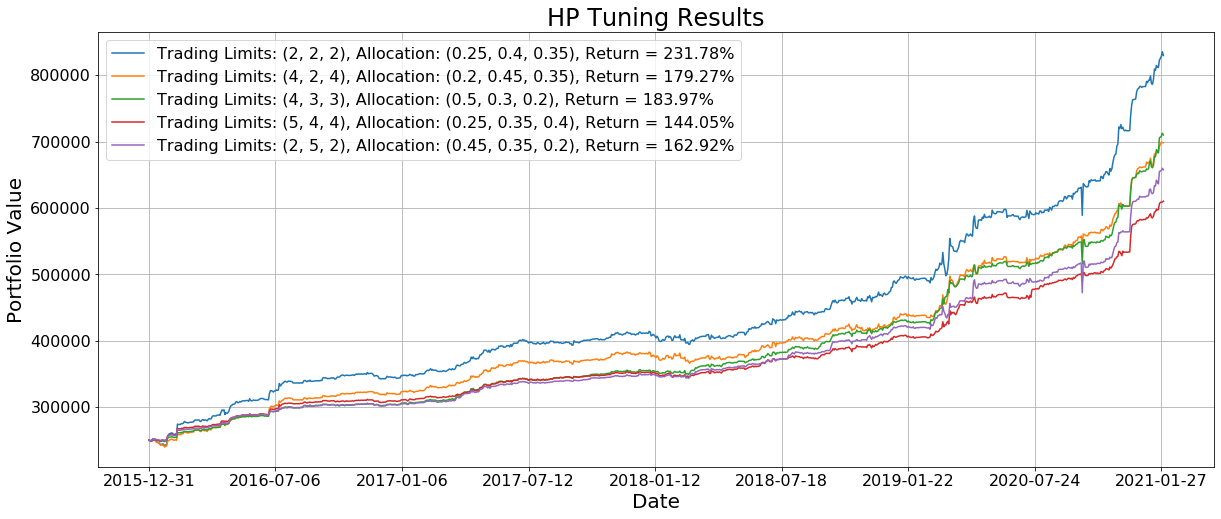

In [39]:
with open('logs/port_alloc_hp_tune.txt') as f:
    pa_res = f.readlines()
f.close()

np.random.seed(0)
indices = [0]
for i in range(4):
    indices.append(np.random.randint(0, len(pa_res)))

plt.figure(figsize = (20,8))
    
for i in indices:
    tl = tuple(map(int, pa_res[i].split("Trading Limits: (")[1].split(')')[0].split(', ')))
    al = tuple(map(float, pa_res[i].split("Allocation: (")[1].split(')')[0].split(', ')))
    trading_limits = {"Australia" : tl[0], "China" : tl[1], "Japan" : tl[2]}
    allocation = {"Australia" : al[0], "China" : al[1], "Japan" : al[2]}
    
    dates1, portfolio_values1, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, 
                                                        start_date = "2016-01-01", end_date = "2019-02-21")
    dates2, portfolio_values2, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, 
                                                        start_date = "2020-02-22", end_date = "2021-01-31", 
                                                        cash = portfolio_values1[-1])
    dates = dates1 + dates2[1:]
    pv = portfolio_values1 + portfolio_values2[1:]
    ret = np.round(100*(pv[-1] - pv[0])/pv[0], 2)

    plt.plot(pv, label = f'Trading Limits: {tl}, Allocation: {al}, Return = {ret}%')
    xticks_indices = np.arange(0, len(dates), (len(dates)-1)//8)
    plt.xticks(xticks_indices, itemgetter(*xticks_indices)(dates), fontsize = 16)
    plt.yticks(fontsize = 16)
    
plt.grid(True)
plt.title(f'HP Tuning Results', fontsize = 24)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Portfolio Value', fontsize = 20)
plt.legend(prop={'size': 16})
plt.savefig('visualizations/hp_tune.pdf')
plt.savefig('visualizations/hp_tune.png')

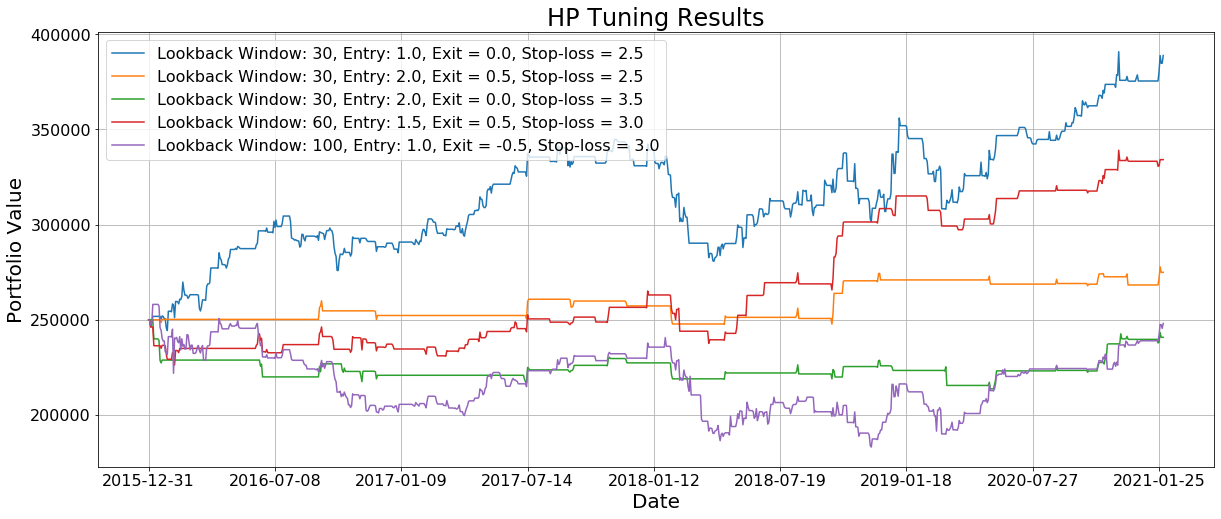

In [62]:
with open(f'historical_data/{country}/{adr}/logs/hp_log_v3b.txt') as f:
    local_res = f.readlines()
f.close()

(country, adr) = ('China', 'SNP_386')
merged_df = data_processing(country, adr, fx_dict)


indices = [1]
for i in range(4):
    indices.append(np.random.randint(2, len(local_res)))

plt.figure(figsize = (20,8))
    
for i in indices:
    best_hps = tuple(map(float, local_res[i].split("(")[1].split(")")[0].split(', ')))
    _, _, portfolio_values1, _, dates1 = pairs_trade_v3b(merged_df, 
                                                         cash = 250000,
                                                         lookback = int(best_hps[0]), 
                                                         entry_cond1_val = best_hps[1], 
                                                         entry_cond2_val = best_hps[1],
                                                         exit_cond1_val = best_hps[2],
                                                         exit_cond2_val = best_hps[2],
                                                         stop_loss_cond1 = best_hps[3],
                                                         stop_loss_cond2 = best_hps[3], 
                                                         end_date = "2019-02-21")
    _, _, portfolio_values2, _, dates2 = pairs_trade_v3b(merged_df,
                                                         lookback = int(best_hps[0]), 
                                                         entry_cond1_val = best_hps[1], 
                                                         entry_cond2_val = best_hps[1],
                                                         exit_cond1_val = best_hps[2],
                                                         exit_cond2_val = best_hps[2],
                                                         stop_loss_cond1 = best_hps[3],
                                                         stop_loss_cond2 = best_hps[3],
                                                         start_date = "2020-02-22",
                                                         cash = portfolio_values1[-1])

    dates = dates1 + dates2[1:]
    pv = portfolio_values1 + portfolio_values2[1:]
    ret = np.round(100*(pv[-1] - pv[0])/pv[0], 2)

    plt.plot(pv, label = f'Lookback Window: {int(best_hps[0])}, Entry: {best_hps[1]}, Exit = {best_hps[2]}, Stop-loss = {best_hps[3]}')
    xticks_indices = np.arange(0, len(dates), (len(dates)-1)//8)
    plt.xticks(xticks_indices, itemgetter(*xticks_indices)(dates), fontsize = 16)
    plt.yticks(fontsize = 16)
    
plt.grid(True)
plt.title(f'HP Tuning Results', fontsize = 24)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Portfolio Value', fontsize = 20)
plt.legend(prop={'size': 16})
plt.savefig('visualizations/hp_tune_local.pdf')
plt.savefig('visualizations/hp_tune_local.png')

# Visualizing Final PnL

#### Want to see final results with best hyperparameters

Plot IS portfolio value for the best hyperparameters, as well as the OOS results and Stress Testing results with S&P500 as benchmark.

In [9]:
start = datetime.datetime(2015, 12, 31)
end = datetime.datetime(2021, 1, 31)

SP500 = web.DataReader(['sp500'], 'fred', start, end)

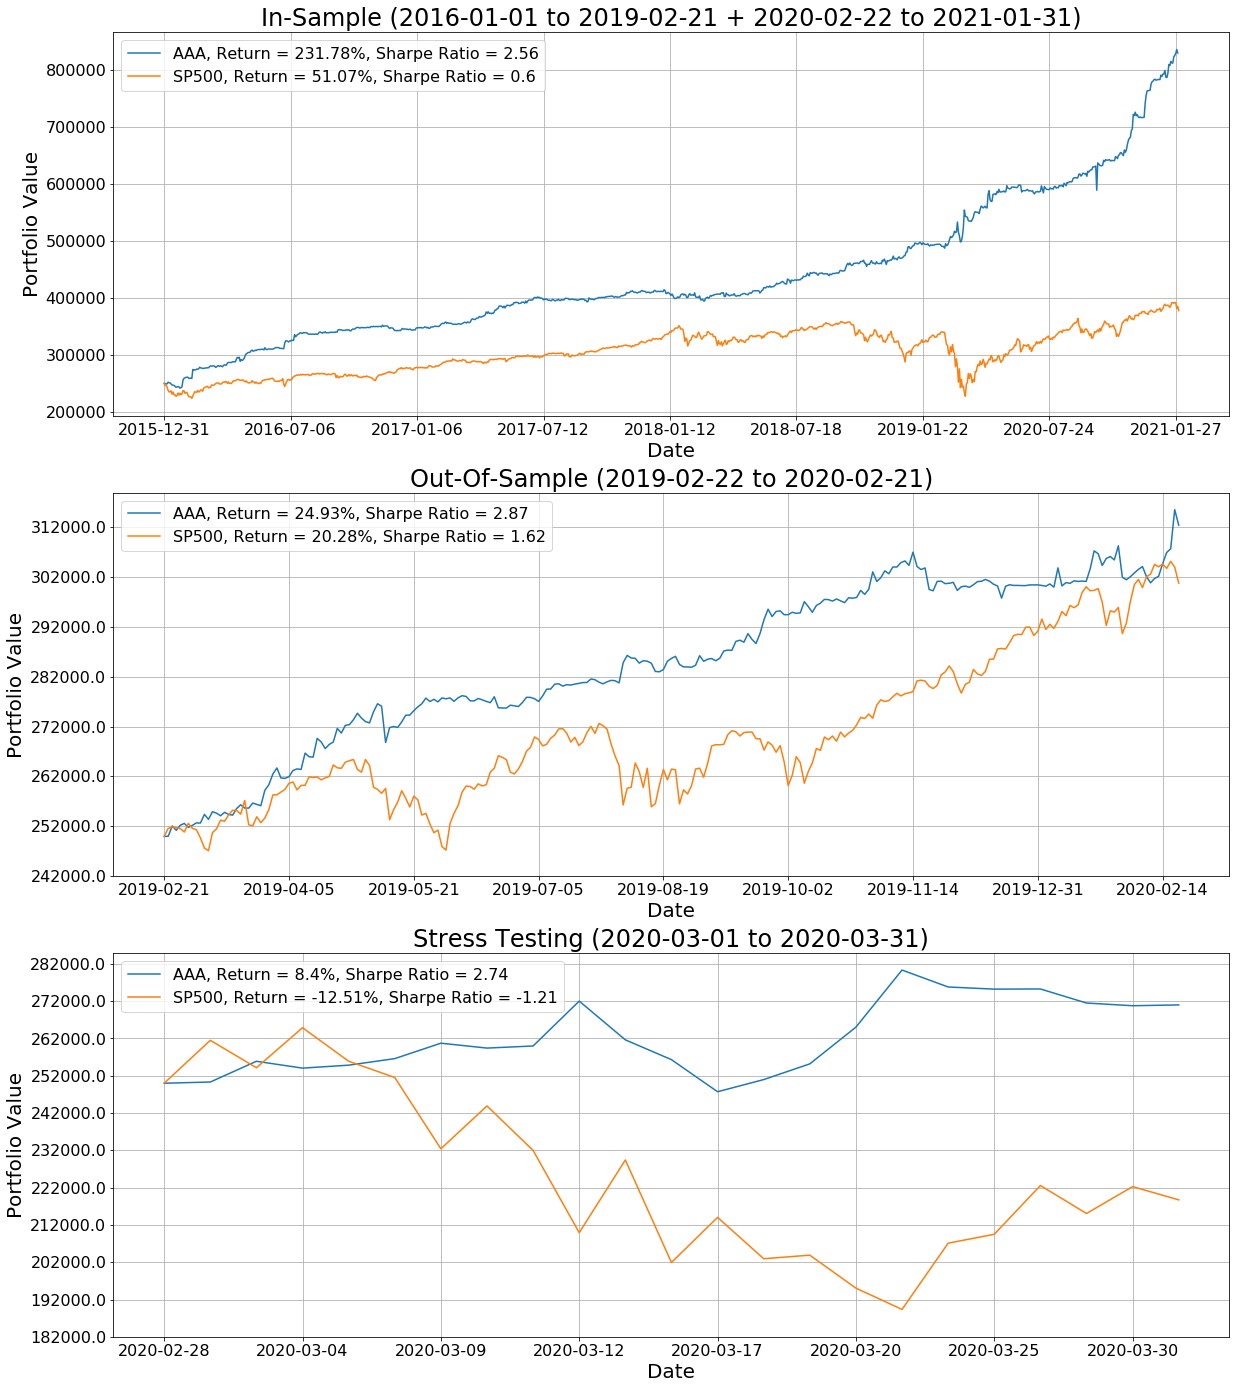

In [47]:
fig, axs = plt.subplots(3, figsize = (20, 24))
    
trading_limits = {"Australia" : 2, "China" : 2, "Japan" : 2}
allocation = {"Australia" : 0.25, "China" : 0.4, "Japan" : 0.35}

# In Sample

# AAA
is_dates1, is_portfolio_values1, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                                          list_pairs, start_date = "2016-01-01", end_date = "2019-02-21")
is_dates2, is_portfolio_values2, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                                          list_pairs, start_date = "2020-02-22", end_date = "2021-01-31", 
                                                          cash = is_portfolio_values1[-1])
is_dates = is_dates1 + is_dates2[1:]
is_pv = is_portfolio_values1 + is_portfolio_values2[1:]
is_ret = np.round(100*(is_pv[-1] - is_pv[0])/is_pv[0], 2)
is_sr = calc_sharpe(is_pv)

# S&P
is_sp5001 = SP500.loc[[datetime.datetime(d[0], d[1], d[2]) for d in [tuple(map(int, dd.split("-"))) for dd in is_dates1]]]
is_sp1 = np.asarray(is_sp5001['sp500'] * 250000/is_sp5001['sp500'].iloc[0])
is_sp5002 = SP500.loc[[datetime.datetime(d[0], d[1], d[2]) for d in [tuple(map(int, dd.split("-"))) for dd in is_dates2]]]
is_sp2 = np.asarray(is_sp5002['sp500'] * is_sp1[-1] / is_sp5002['sp500'].iloc[0])
is_sp = np.concatenate((is_sp1, is_sp2), axis = 0)
is_sp_ret = np.round(100*(is_sp[-1] - is_sp[0])/is_sp[0], 2)
is_sp_sr = calc_sharpe(is_sp)

# Graph
axs[0].plot(is_pv, label = f'AAA, Return = {is_ret}%, Sharpe Ratio = {is_sr}')
axs[0].plot(is_sp, label = f'SP500, Return = {is_sp_ret}%, Sharpe Ratio = {is_sp_sr}')
xticks_indices = np.arange(0, len(is_dates), (len(is_dates)-1)//8)
axs[0].set_xticks(xticks_indices)
axs[0].set_xticklabels(itemgetter(*xticks_indices)(is_dates), fontsize = 16)
axs[0].set_xlabel("Date", fontsize = 20)
yticks_indices = np.arange(200000, 875000, 100000)
axs[0].set_yticks(yticks_indices)
axs[0].set_yticklabels(yticks_indices,fontsize = 16)
axs[0].set_ylabel("Portfolio Value", fontsize = 20)
    
axs[0].grid(True)
axs[0].legend(prop={'size': 16})
axs[0].set_title(f'In-Sample (2016-01-01 to 2019-02-21 + 2020-02-22 to 2021-01-31)', fontsize = 24)

# Out of Sample

# AAA
oos_dates, oos_pv, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                            list_pairs, start_date = "2019-02-22", end_date = "2020-02-21")
oos_ret = np.round(100*(oos_pv[-1] - oos_pv[0])/oos_pv[0], 2)
oos_sr = calc_sharpe(oos_pv)

# S&P
oos_sp500 = SP500.loc[[datetime.datetime(d[0], d[1], d[2]) for d in [tuple(map(int, dd.split("-"))) for dd in oos_dates]]]
oos_sp = np.asarray(oos_sp500['sp500'] * 250000/oos_sp500['sp500'].iloc[0])

oos_sp_ret = np.round(100*(oos_sp[-1] - oos_sp[0])/oos_sp[0], 2)
oos_sp_sr = calc_sharpe(oos_sp)

# Graph
axs[1].plot(oos_pv, label = f'AAA, Return = {oos_ret}%, Sharpe Ratio = {oos_sr}')
axs[1].plot(oos_sp, label = f'SP500, Return = {oos_sp_ret}%, Sharpe Ratio = {oos_sp_sr}')
xticks_indices = np.arange(0, len(oos_dates), (len(oos_dates)-1)//8)
axs[1].set_xticks(xticks_indices)
axs[1].set_xticklabels(itemgetter(*xticks_indices)(oos_dates), fontsize = 16)
axs[1].set_xlabel("Date", fontsize = 20)
yticks_indices = np.arange(2.42e5, 3.18e5, 1e4)
axs[1].set_yticks(yticks_indices)
axs[1].set_yticklabels(yticks_indices,fontsize = 16)
axs[1].set_ylabel("Portfolio Value", fontsize = 20)
    
axs[1].grid(True)
axs[1].legend(prop={'size': 16})
axs[1].set_title(f'Out-Of-Sample (2019-02-22 to 2020-02-21)', fontsize = 24)

# Stress Testing

# AAA
st_dates, st_pv, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                          list_pairs, start_date = "2020-03-01", end_date = "2020-03-31")
st_ret = np.round(100*(st_pv[-1] - st_pv[0])/st_pv[0], 2)
st_sr = calc_sharpe(st_pv)

# S&P
st_sp500 = SP500.loc[[datetime.datetime(d[0], d[1], d[2]) for d in [tuple(map(int, dd.split("-"))) for dd in st_dates]]]
st_sp = np.asarray(st_sp500['sp500'] * 250000/st_sp500['sp500'].iloc[0])
st_sp_ret = np.round(100*(st_sp[-1] - st_sp[0])/st_sp[0], 2)
st_sp_sr = calc_sharpe(st_sp)

# Graph
axs[2].plot(st_pv, label = f'AAA, Return = {st_ret}%, Sharpe Ratio = {st_sr}')
axs[2].plot(st_sp, label = f'SP500, Return = {st_sp_ret}%, Sharpe Ratio = {st_sp_sr}')
xticks_indices = np.arange(0, len(st_dates), (len(st_dates)-1)//6)
axs[2].set_xticks(xticks_indices)
axs[2].set_xticklabels(itemgetter(*xticks_indices)(st_dates), fontsize = 16)
axs[2].set_xlabel("Date", fontsize = 20)
yticks_indices = np.arange(1.82e5, 2.83e5, 1e4)
axs[2].set_yticks(yticks_indices)
axs[2].set_yticklabels(yticks_indices,fontsize = 16)
axs[2].set_ylabel("Portfolio Value", fontsize = 20)

axs[2].grid(True)
axs[2].legend(prop={'size': 16})
axs[2].set_title(f'Stress Testing (2020-03-01 to 2020-03-31)', fontsize = 24)
plt.savefig('visualizations/final_results.pdf')
plt.savefig('visualizations/final_results.png')

# Visualize Portfolio Allocation

#### Want to see the differences in each of the countries

Plot the portfolio value for each of the three countries during IS and OOS on the same graph.

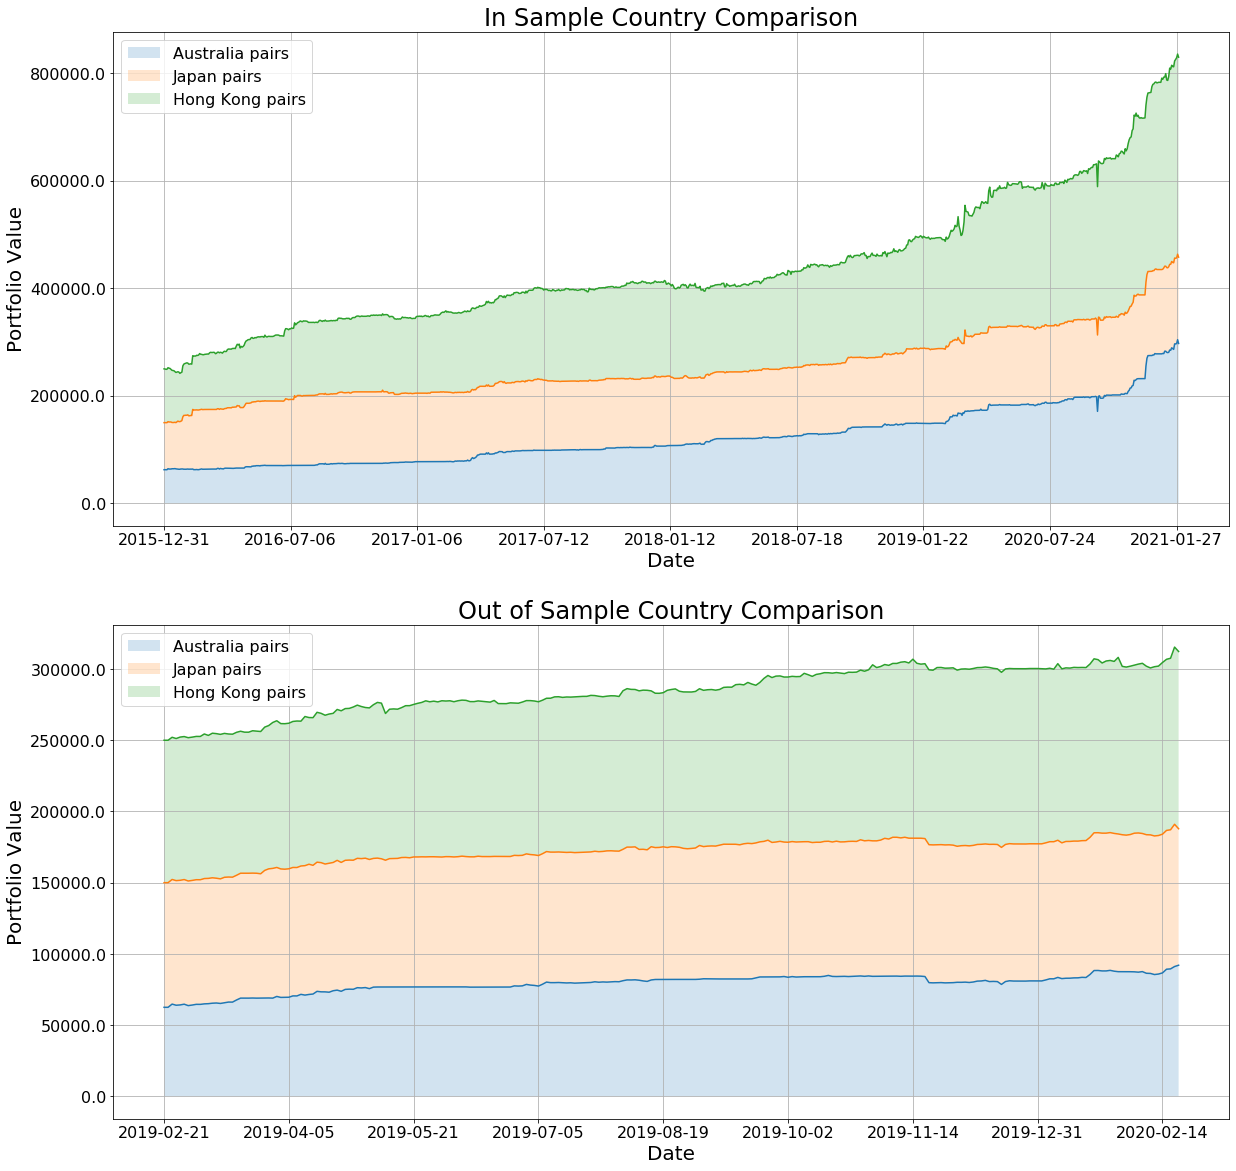

In [74]:
fig, axs = plt.subplots(2, figsize = (20, 20))

def plot_country(dates, pv, ax):
    # dates, pv: [0] = aus, [1] = jap, [2] = china
    aus = list( map(add, pv[0], [-250000 * 0.75] * len(pv[0])) )
    jap = list( map(add, pv[1], [-250000 * 0.4] * len(pv[1])) )
    chi = pv[2]
    
    ax.plot(aus)
    ax.plot(jap) 
    ax.plot(chi) 
    ax.fill_between(dates, aus, alpha = 0.2, label = 'Australia pairs')
    ax.fill_between(dates, jap, aus, alpha = 0.2, label = 'Japan pairs')
    ax.fill_between(dates, chi, jap, alpha = 0.2, label = 'Hong Kong pairs')  
    
    ax.grid(True)
    ax.legend(prop={'size': 16})
    ax.set_xlabel("Date", fontsize = 20)
    ax.set_ylabel("Portfolio Value", fontsize = 20)
    xticks_indices = np.arange(0, len(dates), (len(dates)-1)//8)
    ax.set_xticks(xticks_indices)
    ax.set_xticklabels(itemgetter(*xticks_indices)(dates), fontsize = 16)
    if pv[2] == c_pv:
        yticks_indices = np.arange(0, 3.3e5, 5e4)
    else:
        yticks_indices = np.arange(0, 8.5e5, 2e5)
    ax.set_yticks(yticks_indices)
    ax.set_yticklabels(yticks_indices, fontsize = 16)

# In-Sample
dates1, a_pv1, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                        list_pairs_aus, end_date = "2019-02-21")
dates2, a_pv2, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                        list_pairs_aus, start_date = "2020-02-22",
                                        cash = a_pv1[-1])

_, j_pv1, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                        list_pairs_aus + list_pairs_jap, end_date = "2019-02-21")
_, j_pv2, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                        list_pairs_aus + list_pairs_jap, start_date = "2020-02-22",
                                        cash = j_pv1[-1])

_, c_pv1, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                        list_pairs, end_date = "2019-02-21")
_, c_pv2, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                        list_pairs, start_date = "2020-02-22",
                                        cash = c_pv1[-1])

plot_country(dates1 + dates2[1:], [a_pv1 + a_pv2[1:], j_pv1 + j_pv2[1:], c_pv1 + c_pv2[1:]], axs[0])
axs[0].set_title("In Sample Country Comparison", fontsize = 24)

# Out-of-Sample
dates, a_pv, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                          list_pairs_aus, start_date = "2019-02-22", end_date = "2020-02-21")

_, j_pv, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                          list_pairs_jap + list_pairs_aus, start_date = "2019-02-22", end_date = "2020-02-21")

_, c_pv, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                          list_pairs, start_date = "2019-02-22", end_date = "2020-02-21")

axs[1].set_title("Out of Sample Country Comparison", fontsize = 24)
plot_country(dates, [a_pv, j_pv, c_pv], axs[1])
plt.savefig('visualizations/port_alloc_v1.pdf')
plt.savefig('visualizations/port_alloc_v1.png')

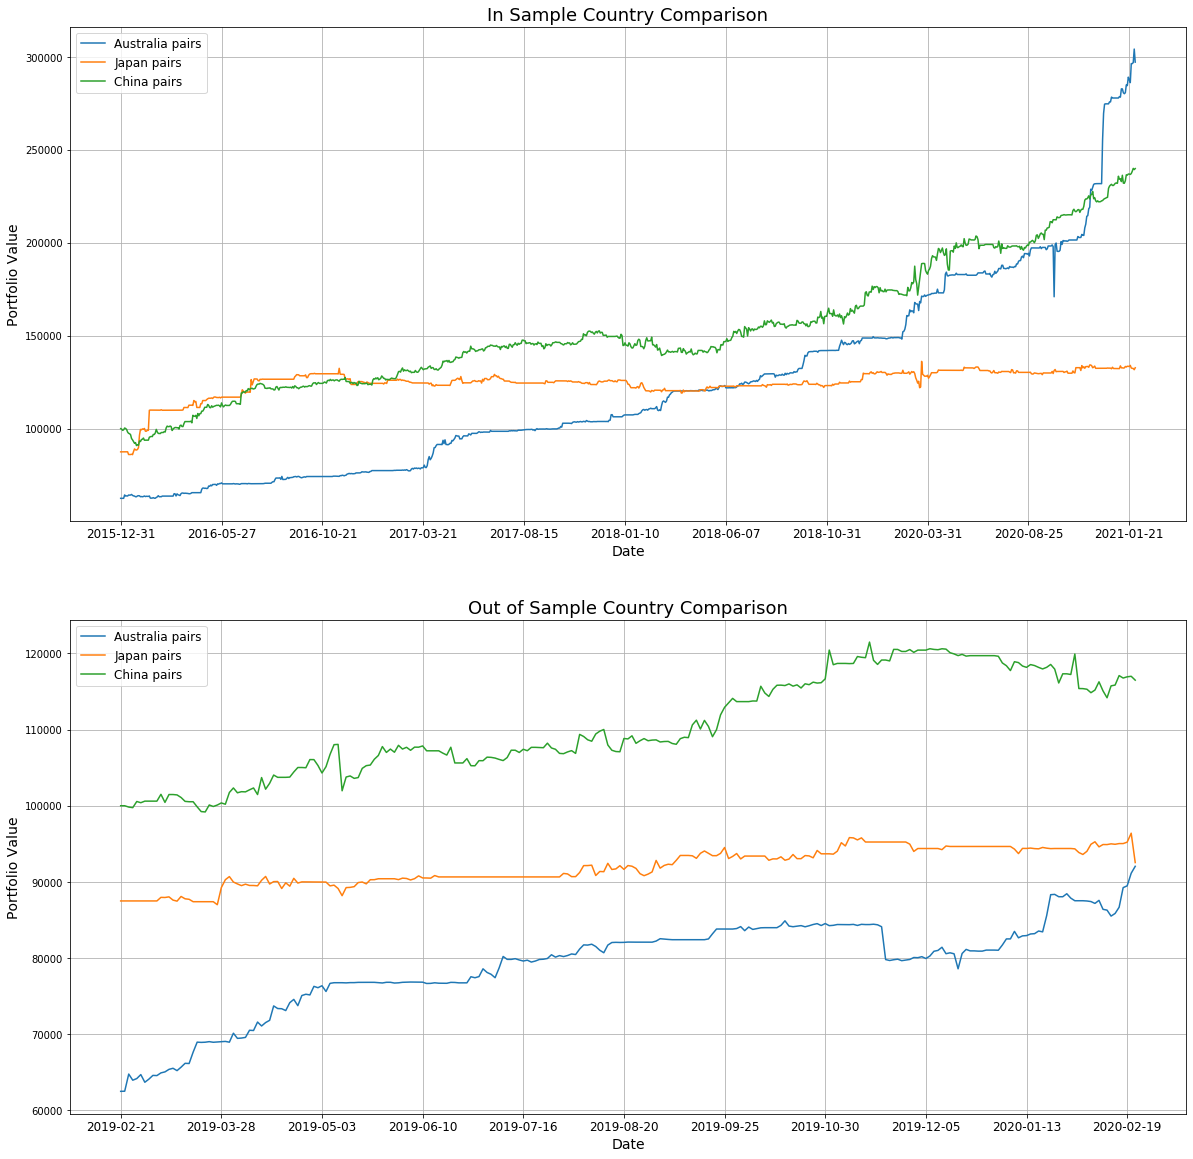

In [12]:
fig, axs = plt.subplots(2, figsize = (20, 20))

def plot_country(dates, pv, ax):
    # dates, pv: [0] = aus, [1] = jap, [2] = china
    aus = list( map(add, pv[0], [-250000 * 0.75] * len(pv[0])) )
    jap = list( map(add, pv[1], [-250000 * 0.65] * len(pv[1])) )
    chi = list( map(add, pv[2], [-250000 * 0.6] * len(pv[2])) )
    
    ax.plot(aus, label = 'Australia pairs')
    ax.plot(jap, label = 'Japan pairs')
    ax.plot(chi, label = 'China pairs')
    
    ax.grid(True)
    ax.legend(prop={'size': 16})
    ax.set_xlabel("Date", fontsize = 20)
    ax.set_ylabel("Portfolio Value", fontsize = 20)
    xticks_indices = np.arange(0, len(dates), (len(dates)-1)//10)
    ax.set_xticks(xticks_indices)
    ax.set_xticklabels(itemgetter(*xticks_indices)(dates), fontsize = 16)
        if pv[2] == c_pv:
        yticks_indices = np.arange(6e4, 1.2e5, 1e4)
    else:
        yticks_indices = np.arange(5e4, 3.2e5, 5e4)
    ax.set_yticks(yticks_indices)
    ax.set_yticklabels(yticks_indices, fontsize = 16)

# In-Sample
dates1, a_pv1, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                        list_pairs_aus, end_date = "2019-02-21")
dates2, a_pv2, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                        list_pairs_aus, start_date = "2020-02-22",
                                        cash = a_pv1[-1])

_, j_pv1, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                        list_pairs_jap, end_date = "2019-02-21")
_, j_pv2, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                        list_pairs_jap, start_date = "2020-02-22",
                                        cash = j_pv1[-1])

_, c_pv1, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                        list_pairs_chi, end_date = "2019-02-21")
_, c_pv2, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                        list_pairs_chi, start_date = "2020-02-22",
                                        cash = c_pv1[-1])

plot_country(dates1 + dates2[1:], [a_pv1 + a_pv2[1:], j_pv1 + j_pv2[1:], c_pv1 + c_pv2[1:]], axs[0])
axs[0].set_title("In Sample Country Comparison", fontsize = 24)

# Out-of-Sample
dates, a_pv, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                          list_pairs_aus, start_date = "2019-02-22", end_date = "2020-02-21")

_, j_pv, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                          list_pairs_jap, start_date = "2019-02-22", end_date = "2020-02-21")

_, c_pv, _, _, _ = final_strategy(df_dict, datelist, trading_limits, allocation, hp, 
                                          list_pairs_chi, start_date = "2019-02-22", end_date = "2020-02-21")

axs[1].set_title("Out of Sample Country Comparison", fontsize = 24)
plot_country(dates, [a_pv, j_pv, c_pv], axs[1])
plt.savefig('visualizations/port_alloc_v2.pdf')
plt.savefig('visualizations/port_alloc_v2.png')

# Visualize Risk

#### Want to see VaR

Plot distributions of daily returns over IS and OOS. Highlight the VaR.

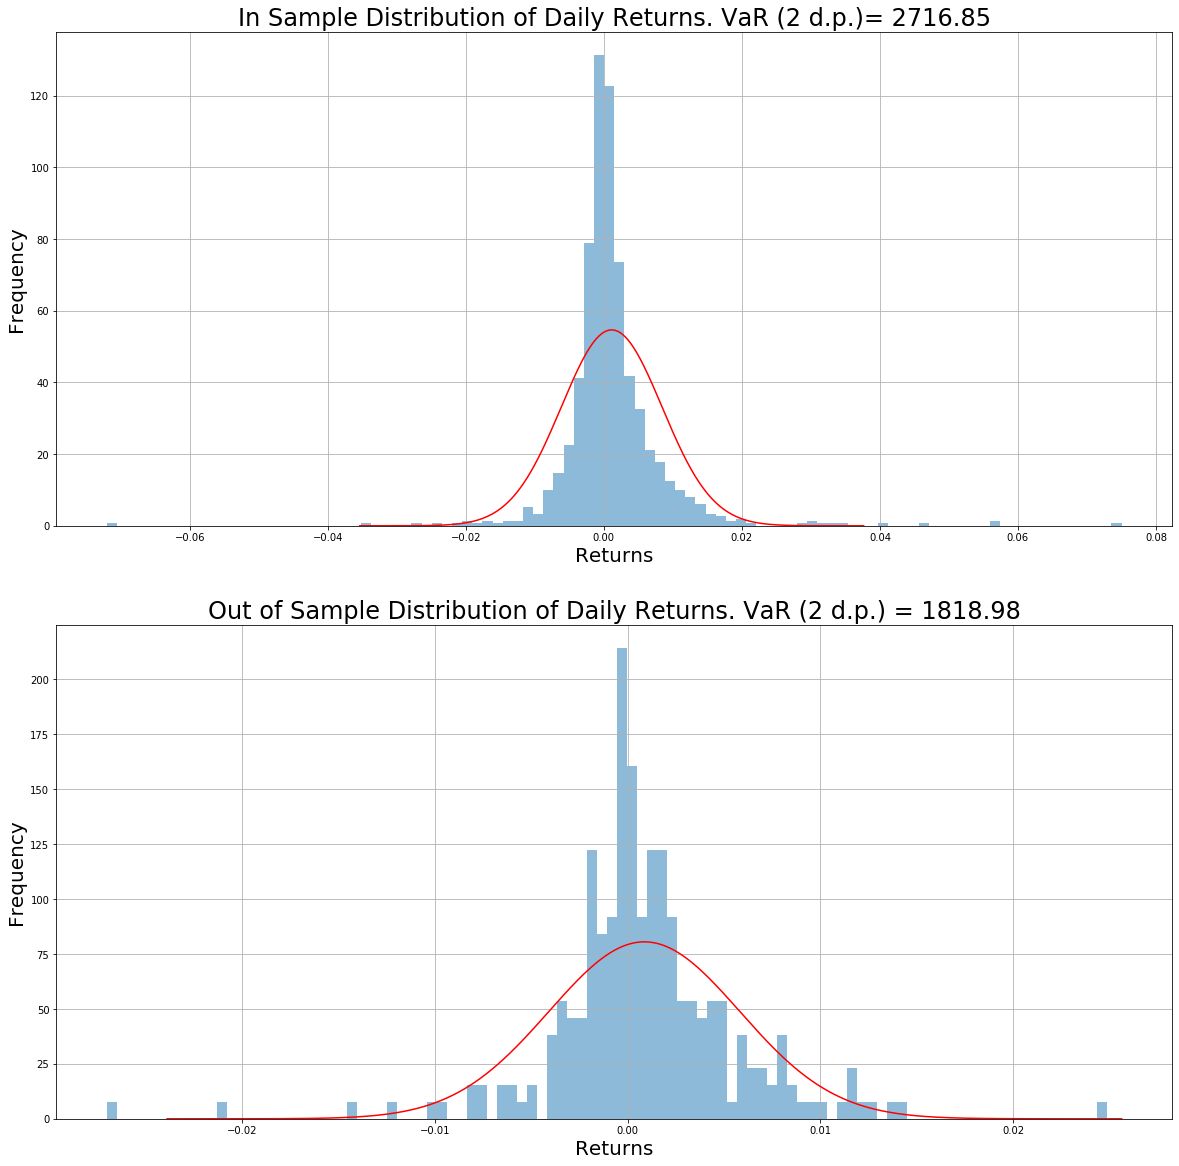

In [52]:
fig, axs = plt.subplots(2, figsize = (20, 20))

def plot_dist(pv, ax):
    returns = np.diff(pv) / pv[1:]
    port_mean = np.mean(returns)
    port_stdev = np.std(returns)
    
    mean_investment = (1 + port_mean) * 250000
    stdev_investment = 250000 * port_stdev
    conf_level1 = 0.05
    cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)
    var = 250000 - cutoff1
    
    ax.hist(returns, bins = 100, density = True, histtype = "stepfilled", alpha = 0.5)
    x = np.linspace(port_mean - 5 * port_stdev, port_mean + 5 * port_stdev, 500)
    ax.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
    
    ax.grid(True)
    ax.set_xlabel("Returns", fontsize = 20)
    ax.set_ylabel("Frequency", fontsize = 20)
    return var

# In-Sample
is_var = plot_dist(is_pv, axs[0])
axs[0].set_title(f"In Sample Distribution of Daily Returns. VaR (2 d.p.)= {is_var:.2f}", fontsize = 24)

# Out-of-Sample
oos_var = plot_dist(oos_pv, axs[1])
axs[1].set_title(f"Out of Sample Distribution of Daily Returns. VaR (2 d.p.) = {oos_var:.2f}", fontsize = 24)

plt.savefig('visualizations/var.pdf')
plt.savefig('visualizations/var.png')